**Descripción del Cuaderno**

Este cuaderno está diseñado para trabajar con modelos de aprendizaje automático utilizando TensorFlow y otras bibliotecas relevantes.

1. **Instalación y Configuración**: Desinstala versiones anteriores de TensorFlow y `tf-keras` e instala TensorFlow 2.15.0.

2. **Importación de Librerías**: Incluye `sklearn` para herramientas de machine learning, `tensorflow` y `keras` para aprendizaje profundo, `numpy` para operaciones numéricas, `os` para manejo de archivos, y `matplotlib` para visualización.

3. **Configuración del Entorno**: Establece semillas para reproducibilidad y configura Matplotlib para mostrar gráficos en línea con tamaños de fuente específicos.

4. **Configuración de Directorios y Funciones para Guardar Figuras**: Define el directorio para guardar imágenes y funciones para guardar figuras y trazar imágenes.

5. **Carga y Preprocesamiento de Datos**: Carga el conjunto de datos Fashion MNIST, normaliza los valores de los píxeles y divide el conjunto de entrenamiento en datos de entrenamiento y validación.

6. **Definición de Métricas y Funciones de Ajuste de Tasa de Aprendizaje**: Incluye una métrica personalizada para precisión redondeada y funciones para ajustar la tasa de aprendizaje.

7. **Funciones para Visualización de Reconstrucciones**: Visualiza las reconstrucciones generadas por el modelo comparadas con las imágenes originales.

8. **Evaluación de Modelos**: Evalúa el modelo en el conjunto de prueba y muestra gráficos de pérdida y precisión durante el entrenamiento.

9. **Definición de Clases y Funciones para Autoencoders Variacionales**: Incluye una función de pérdida escalada y una capa de muestreo para autoencoders variacionales.

10. **Evaluación Avanzada del Discriminador**: Evalúa el discriminador de un GAN generando imágenes falsas y reales, y calcula métricas de rendimiento como la curva ROC y la matriz de confusión.

11. **Instalación de Paquetes Adicionales**: Instala paquetes adicionales para la generación de GIFs y documentación de TensorFlow.

In [1]:
!pip uninstall -y tensorflow tf-keras
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: tf_keras 2.17.0
Uninstalling tf_keras-2.17.0:
  Successfully uninstalled tf_keras-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully u

In [2]:
import sklearn
import tensorflow as tf
from tensorflow import keras
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
# Cargar los datos
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalizar los datos
X_train_full = X_train_full.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.

# Dividir los datos en entrenamiento y validación
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Agregar la dimensión del canal
X_train = np.expand_dims(X_train, axis=-1)  # Agrega la dimensión de canal
X_valid = np.expand_dims(X_valid, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn
import matplotlib.pyplot as plt
import tensorflow as tf

def evaluar_modelo(history, model, X_test):
    # Evaluar el modelo en los datos de prueba
    resultado = model.evaluate(X_test, X_test, verbose=0)
    print(f'Evaluación con test: Loss= {resultado[0]}, Acc= {resultado[1]}')

    # Crear una figura con dos subplots
    plt.figure(figsize=(12, 5))

    # Subplot 1: Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Error')
    plt.legend()

    # Subplot 2: Precisión (accuracy)
    if 'rounded_accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['rounded_accuracy'], label='Acc')
        plt.plot(history.history['val_rounded_accuracy'], label='Val Acc')
        plt.title('Precisión durante el entrenamiento')
        plt.xlabel('Épocas')
        plt.ylabel('Acc')
        plt.legend()

    # Mostrar las gráficas
    plt.show()

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K

# Definición de ScaledBinaryCrossentropy y Sampling
class ScaledBinaryCrossentropy(keras.losses.Loss):
    def __init__(self, scale):
        super(ScaledBinaryCrossentropy, self).__init__()
        self.scale = scale

    def call(self, y_true, y_pred):
        return self.scale * tf.keras.losses.mae(y_true, y_pred)

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
!pip install tf-keras-vis
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(42)
np.random.seed(42)

def plot_cam(layer_name, image, target_class, ax, max_value,min_value, model_for_gradcam, gradcam):
    """
    Genera y plotea el CAM para una imagen dada y una clase objetivo.
    """
    # Ajustar la imagen a la forma correcta si es necesario
    image = image.reshape(1, 28, 28,1)

    # Generar el CAM con GradCAM++ usando la capa especificada
    cam = gradcam(CategoricalScore(target_class), image, penultimate_layer=layer_name, normalize_cam=False)
    avg_intensity = np.mean(cam[0])

    # Plotear la imagen original
    img = ax.imshow(image.squeeze(), cmap='binary')

    # Superponer el CAM como un mapa de calor
    heatmap = ax.imshow(cam[0], cmap='jet',alpha=0.5, vmin=min_value, vmax=max_value)  # Ajustar el rango con vmin y vmax

    # Configuración de la gráfica
    ax.set_title(round(avg_intensity,2))
    ax.axis('off')
    return heatmap

def generate_and_plot_cam_for_output(model, X_test, y_test, layers, output_name, class_mode=True):
    """
    Genera y plotea CAMs para cada capa y salida especificada.

    Args:
        model: Modelo de Keras con el que se generarán los CAMs.
        X_test: Imágenes de prueba.
        y_test: Etiquetas de prueba.
        layers: Lista de nombres de capas para las que se generarán los CAMs.
        output_name: Nombre de la salida que se desea analizar ('classifier', 'reconstruction', 'dkl_loss').
        class_mode: Si es True, generará CAMs para cada clase; si es False, mostrará el valor del CAM para la imagen dada.
    """
    # Configuración para obtener el modelo para GradCAM++
    model_for_gradcam = Model(inputs=model.input, outputs=model.get_layer(output_name).output)
    gradcam = GradcamPlusPlus(model_for_gradcam, model_modifier=ReplaceToLinear(), clone=True)

    # Recorrer cada capa
    for layer in layers:
        print(f'Capa: {layer}')
        for class_label in range(10):
            # Obtener el índice de la primera imagen de la clase actual
            index = np.where(y_test == class_label)[0][0]

            # Configuración de la figura para las 10 clases si estamos en modo clasificación
            if class_mode and output_name == 'classifier':
                fig, axes = plt.subplots(1, 10, figsize=(20, 2))
                # Calcular el valor máximo de los CAMs para esta capa y clase
                cams = [gradcam(CategoricalScore(target_class), X_test[index].reshape(1, 28, 28,1), penultimate_layer=layer, normalize_cam=False)[0] for target_class in range(10)]
                max_value = np.max(cams)
                min_value = np.min(cams)

                # Generar y mostrar los CAMs para cada clase
                heatmaps = []
                for target_class in range(10):
                    ax = axes[target_class]
                    heatmap = plot_cam(layer, X_test[index], target_class, ax, max_value,min_value, model_for_gradcam, gradcam)
                    heatmaps.append(heatmap)

                # Añadir una colorbar común para esta fila de imágenes
                fig.colorbar(heatmaps[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
                plt.show()
            else:
                # Modo para las otras salidas
                fig, ax = plt.subplots(1, 1, figsize=(5, 5))
                cam = gradcam(CategoricalScore(0), X_test[index].reshape(1, 28, 28,1), penultimate_layer=layer, normalize_cam=False)
                avg_intensity = np.mean(cam[0])
                ax.imshow(X_test[index].squeeze(), cmap='binary')
                ax.imshow(cam[0], cmap='jet', alpha=0.5)
                ax.set_title(f'{output_name}, Avg Intensity: {avg_intensity:.2f}')
                ax.axis('off')
                plt.show()
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc

def show_reconstructions(model, images=X_valid, n_images=5):
    """
    Muestra las imágenes originales y sus reconstrucciones generadas por el modelo.

    Parámetros:
    model: El modelo entrenado de autoencoder variacional.
    images: Las imágenes de entrada para generar las reconstrucciones (por defecto, X_valid).
    n_images: Número de imágenes a mostrar.
    """
    # Obtener las reconstrucciones del modelo
    reconstructions = model.predict(images[:n_images])[0]

    # Crear una figura con subplots para mostrar las imágenes
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        # Mostrar imagen original
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        # Mostrar imagen reconstruida
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

def plot_multiple_images(images, n_cols=None):
    """
    Muestra múltiples imágenes en una cuadrícula.

    Parámetros:
    images: Lista de imágenes a mostrar.
    n_cols: Número de columnas en la cuadrícula. Si es None, se usa el número de imágenes.
    """
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    # Eliminar el canal si es unidimensional
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

def evaluar_modelo(history, model, X_test, y_test, num_classes=10):
    """
    Evalúa el modelo y muestra las métricas y gráficas de desempeño.

    Parámetros:
    history: Historial del entrenamiento del modelo.
    model: El modelo entrenado de autoencoder variacional.
    X_test: Datos de entrada de prueba.
    y_test: Etiquetas de prueba.
    num_classes: Número de clases en la salida de clasificación.
    """
    # Obtener las predicciones del modelo
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs[-1], axis=1)

    # Calcular la precisión de clasificación usando accuracy_score
    accuracy = accuracy_score(y_test, y_pred)

    # Evaluar el modelo en los datos de prueba usando model.evaluate
    resultado = model.evaluate(X_test, {"reconstruction": X_test, "dkl_loss": np.zeros((X_test.shape[0],)), "classifier": y_test}, verbose=0)
    print(f'Evaluación con test: Reconstruction Loss = {resultado[1]}, DKL Loss = {resultado[2]}, Classification Accuracy = {accuracy:.4f}')

    # Crear una figura con dos subplots para mostrar la pérdida y precisión
    plt.figure(figsize=(18, 5))

    # Subplot 1: Pérdida (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
    plt.plot(history.history['val_reconstruction_loss'], label='Val Reconstruction Loss')
    plt.plot(history.history['dkl_loss_loss'], label='DKL Loss')
    plt.plot(history.history['val_dkl_loss_loss'], label='Val DKL Loss')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Error')
    plt.legend()

    # Subplot 2: Precisión (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['classifier_accuracy'], label='Training Classification Accuracy')
    plt.plot(history.history['val_classifier_accuracy'], label='Validation Classification Accuracy')
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    # Mostrar las gráficas
    plt.show()

def evaluate_classifier(test_images, test_labels, model, num_classes=10):
    """
    Evalúa el rendimiento del clasificador, incluyendo la curva ROC y la matriz de confusión.

    Parámetros:
    test_images: Imágenes de prueba.
    test_labels: Etiquetas de prueba.
    model: El modelo clasificador.
    num_classes: Número de clases en la salida de clasificación.
    """
    # Obtener las predicciones del modelo
    y_pred_probs = model.predict(test_images)
    y_pred = np.argmax(y_pred_probs[-1], axis=1)

    # Calcular la curva ROC y el AUC para cada clase
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels == i, y_pred_probs[-1][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(test_labels, y_pred, normalize='true')

    # Configuración de la figura con dos gráficos (ROC y matriz de confusión)
    fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 8))

    # Graficar la curva ROC para cada clase
    for i in range(num_classes):
        ax1.plot(fpr[i], tpr[i], lw=2, label=f'{i}')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic')
    ax1.legend(loc="lower right")

    # Graficar la matriz de confusión normalizada
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[f'{i}' for i in range(num_classes)])
    disp.plot(cmap=plt.cm.Blues, ax=ax2, colorbar=True)
    ax2.set_title('Normalized Confusion Matrix')

    plt.show()

    # Calcular las métricas y generar el reporte de clasificación
    precision = precision_score(test_labels, y_pred, average='weighted')
    recall = recall_score(test_labels, y_pred, average='weighted')
    f2 = fbeta_score(test_labels, y_pred, beta=2, average='weighted')

    # Imprimir las métricas de precisión, recall y F2-score
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F2-score: {f2:.4f}")

    # Generar e imprimir el reporte de clasificación
    report = classification_report(test_labels, y_pred, target_names=[f'{i}' for i in range(num_classes)])
    print(report)

import tensorflow as tf
import tensorflow as tf
from tensorflow import keras

import tensorflow as tf
from tensorflow import keras

class mmd_loss(keras.losses.Loss):
    def __init__(self):
        super(mmd_loss, self).__init__()

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Calcular la matriz de distancias entre y_true
        dist_matrix = self.cdist(y_true, y_true)

        # Calcular la parte triangular superior, excluyendo la diagonal
        upper_triangular = tf.linalg.band_part(dist_matrix, 0, -1)  # Parte triangular superior
        upper_triangular = tf.linalg.set_diag(upper_triangular, tf.zeros(tf.shape(dist_matrix)[0]))  # Excluir la diagonal

        # Extraer los valores no cero de la parte triangular superior
        non_zero_elements = tf.boolean_mask(upper_triangular, upper_triangular > 0)

        # Calcular sigma dinámicamente como la media de la triangular superior
        sigma = tf.reduce_mean(non_zero_elements)

        # Calcular las matrices de kernel usando el sigma dinámico
        K_yy = self.gaussian_kernel_matrix(y_true, y_true, sigma)
        K_ff = self.gaussian_kernel_matrix(y_pred, y_pred, sigma)
        K_yf = self.gaussian_kernel_matrix(y_true, y_pred, sigma)

        # Calcular la MMD: usar reduce_mean para obtener un escalar
        mmd = tf.reduce_mean(K_yy) + tf.reduce_mean(K_ff) - 2 * tf.reduce_mean(K_yf)
        # plt.imshow(K_yf)
        # plt.colorbar()
        # plt.show()
        return 50*mmd

    def cdist(self, XA, XB):
        """
        Calcula la distancia euclidiana entre cada par de puntos de XA y XB.
        """
        # Expandir las dimensiones para hacer las diferencias entre todos los pares
        XA_exp = tf.expand_dims(XA, axis=1)  # (m, 1, d)
        XB_exp = tf.expand_dims(XB, axis=0)  # (1, n, d)
        # Calcular la distancia euclidiana
        dist_matrix = tf.reduce_sum(tf.square(XA_exp - XB_exp), axis=-1)
        return dist_matrix

    def gaussian_kernel_matrix(self, x, y, sigma):
        kernel = tf.exp(-self.cdist(x, y) / (2 * sigma ** 2))
        return kernel



4422102/4422102 [==============================] - 0s 0us/step
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.3 MB/s eta 0:00:00


# Custom loss MMD

In [5]:
class mmd_loss(keras.losses.Loss):
    def __init__(self,plot=False):
        super(mmd_loss, self).__init__()
        self.plot=plot

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Calcular la matriz de distancias entre y_true
        dist_matrix = self.cdist(y_true, y_true)

        # Calcular la parte triangular superior, excluyendo la diagonal
        upper_triangular = tf.linalg.band_part(dist_matrix, 0, -1)  # Parte triangular superior
        upper_triangular = tf.linalg.set_diag(upper_triangular, tf.zeros(tf.shape(dist_matrix)[0]))  # Excluir la diagonal

        # Extraer los valores no cero de la parte triangular superior
        non_zero_elements = tf.boolean_mask(upper_triangular, upper_triangular > 0)

        # Calcular sigma dinámicamente como la media de la triangular superior
        sigma = tf.reduce_mean(non_zero_elements)

        # Calcular las matrices de kernel usando el sigma dinámico
        K_yy = self.gaussian_kernel_matrix(y_true, y_true, sigma)
        K_ff = self.gaussian_kernel_matrix(y_pred, y_pred, sigma)
        K_yf = self.gaussian_kernel_matrix(y_true, y_pred, sigma)

        # Calcular la MMD: usar reduce_mean para obtener un escalar
        mmd = tf.reduce_mean(K_yy) + tf.reduce_mean(K_ff) - 2 * tf.reduce_mean(K_yf)
        if self.plot:
            plt.imshow(K_yf)
            plt.colorbar()
            plt.show()
        return 50*mmd

    def cdist(self, XA, XB):
        """
        Calcula la distancia euclidiana entre cada par de puntos de XA y XB.
        """
        # Expandir las dimensiones para hacer las diferencias entre todos los pares
        XA_exp = tf.expand_dims(XA, axis=1)  # (m, 1, d)
        XB_exp = tf.expand_dims(XB, axis=0)  # (1, n, d)
        # Calcular la distancia euclidiana
        dist_matrix = tf.reduce_sum(tf.square(XA_exp - XB_exp), axis=-1)
        return dist_matrix

    def gaussian_kernel_matrix(self, x, y, sigma):
        kernel = tf.exp(-self.cdist(x, y) / (2 * sigma ** 2))
        return kernel

## Evaluación MMD

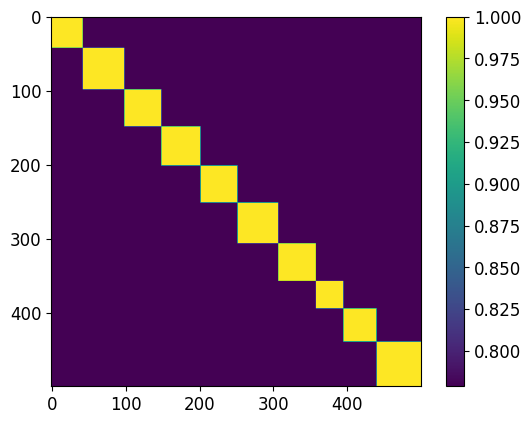

In [6]:
import tensorflow as tf
import numpy as np

# Generar datos sintéticos
num_samples = 500  # Número de muestras
num_classes = 10    # Número de clases

# Etiquetas sintéticas: enteros aleatorios entre 0 y num_classes - 1
y_true = np.random.randint(0, num_classes, size=num_samples)

# Predicciones sintéticas: probabilidades aleatorias (suma de probabilidades por fila = 1)
y_pred = np.random.rand(num_samples, num_classes)
y_pred = y_pred / np.sum(y_pred, axis=1, keepdims=True)  # Normalizar para que sean probabilidades
ind= np.argsort(y_true)
ind
# Convertir y_true a "one-hot" para que coincida con y_pred en dimensiones
y_true_one_hot = tf.keras.utils.to_categorical(y_true[ind], num_classes=num_classes)

# Convertir a tensores de TensorFlow
y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.int32)  # Etiquetas como enteros
y_true_one_hot_tensor = tf.convert_to_tensor(y_true_one_hot, dtype=tf.float32)  # Etiquetas "one-hot"
y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.float32)  # Predicciones como flotantes

# Aplicar la función de pérdida sparse_categorical_crossentropy
loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_tensor, y_pred_tensor)

# Instanciar la pérdida personalizada con sigma=1.0
mmd_loss_fn = mmd_loss(plot=True)
# Calcular la pérdida MMD utilizando las etiquetas "one-hot"
mmd_value = mmd_loss_fn(y_true_one_hot_tensor, y_true_one_hot_tensor)


#Modelo

**Descripción del Código**

1. **Configuración Inicial**:
   - Se configuran semillas para reproducibilidad en TensorFlow y NumPy.
   - Se definen parámetros para la función de pérdida y el tamaño de los codificadores.
   - `losses` define la función de pérdida escalada para el autoencoder variacional.

2. **Definición de la Arquitectura del Modelo**:
   - **Encoder**:
     - Se construye con capas convolucionales seguidas de `MaxPooling` para extraer características y reducir la dimensionalidad.
     - Utiliza `LeakyReLU` como función de activación.
     - Finalmente, las características extraídas se aplanan y se pasan a través de capas densas para obtener las medias (`codings_mean`) y logaritmos de varianzas (`codings_log_var`) de las codificaciones.
     - La capa `Sampling` genera las codificaciones finales a partir de estas medias y varianzas.
     - Se añade una capa densa para la salida de clasificación (`classifier_output`), con activación `softmax` para clasificación en múltiples clases.

   - **Decoder**:
     - Comienza con una capa densa que expande las codificaciones a una forma adecuada para la reconstrucción.
     - Utiliza capas `Conv2DTranspose` para reconstruir la imagen original desde las codificaciones.
     - Se aplican `BatchNormalization` y `LeakyReLU` después de cada capa convolucional transpuesta.

3. **Definición de Modelos**:
   - `variational_encoder` es el modelo del encoder que toma las imágenes de entrada y produce las codificaciones y la salida de clasificación.
   - `variational_decoder` es el modelo del decoder que toma las codificaciones y produce las imágenes reconstruidas.

4. **Pérdida DKL (Kullback-Leibler Divergence)**:
   - Se calcula la pérdida DKL como una métrica adicional y se normaliza.
   - `dkl_output` es la salida de la pérdida DKL que se usa en la compilación del modelo.

5. **Compilación del Modelo**:
   - `variational_ae` combina el encoder y el decoder en un solo modelo con tres salidas: reconstrucción, pérdida DKL y salida de clasificación.
   - Se compila el modelo con las pérdidas definidas para cada salida y se usa la métrica de precisión para la salida de clasificación.

6. **Entrenamiento del Modelo**:
   - El modelo se entrena utilizando `X_train` y `y_train` para las imágenes y las etiquetas, respectivamente.
   - Se realiza la validación utilizando `X_valid` y `y_valid` con las mismas pérdidas y métricas definidas para la validación.

Este código define y entrena un autoencoder variacional con capacidades de clasificación, utilizando un encoder y un decoder para la reconstrucción de imágenes y la clasificación de etiquetas.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy

# Definir Sampling layer
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Definir el modelo basado en la estructura propuesta
def model_class(input_shape=(28, 28, 1), num_classes=10, latent_dim=128):
    # Encoder
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, kernel_size=2,activation='leaky_relu', padding='same', name='conv1')(inputs)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=2, activation='leaky_relu', padding='same', name='conv2')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(256, kernel_size=2, activation='leaky_relu', padding='same', name='conv3')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128, activation='leaky_relu', name='Capa_h')(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling(name='sampling')([z_mean, z_log_var])
    latent_loss = -5 * 0.5 * K.sum(1 +z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=-1)
    dkl_output = K.mean(latent_loss) / 784.0
    dkl_output = keras.layers.Lambda(lambda x: x, name="dkl_loss")(dkl_output)
        # Softmax output (classification)
    softmax_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(z)

    # Decoder
    x = tf.keras.layers.Dense(7 * 7 * 64, activation='leaky_relu')(z)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(64,activation='leaky_relu', kernel_size=3, strides=2, padding="same", name='ConvT1')(x)
    #x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(32, activation='leaky_relu',kernel_size=3, strides=2, padding="same", name='ConvT2')(x)
    #x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(16,activation='leaky_relu', kernel_size=3, strides=1, padding="same", name='ConvT3')(x)
    #x = tf.keras.layers.LeakyReLU()(x)
    reconstruction = tf.keras.layers.Conv2DTranspose(input_shape[2], kernel_size=3, padding="same", activation="sigmoid", name='reconstruction')(x)

    # VAE Model
    vae = tf.keras.models.Model(inputs, [reconstruction,dkl_output , softmax_output], name='vae')
    return vae

# Definir la pérdida de reconstrucción
def reconstruction_loss(y_true, y_pred):
    binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
    return binary_crossentropy(y_true, y_pred)

# Definir la pérdida DKL
def dkl_loss(y_true, y_pred):
    return y_pred  # El valor ya está calculado como la salida

# Definir la pérdida MMD (ya asumimos que la has definido como mmd_loss en otro lugar)
# Aquí utilizamos la versión anterior o una versión adaptada de mmd_loss

# Configurar el modelo
input_shape = (28, 28, 1)
num_classes = 10
latent_dim = 256
learning_rate = 1e-3
model = model_class(input_shape, num_classes, latent_dim)
# Compilación del modelo con pérdidas múltiples
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss={'reconstruction': reconstruction_loss,
                    'dkl_loss': dkl_loss,
                    'classifier': mmd_loss()},
              loss_weights={'reconstruction': 0.4,
                            'dkl_loss': 0.2,
                            'classifier': 0.4},
              metrics={'classifier': ['accuracy']}
             )

# Datos de entrenamiento (X_train, y_train) y validación (X_valid, y_valid)
# Por simplicidad, aquí asumimos que ya están definidos como variables

# Entrenamiento del modelo
history = model.fit(X_train, {"reconstruction": X_train, "dkl_loss": np.zeros((X_train.shape[0], latent_dim)), "classifier": tf.keras.utils.to_categorical(y_train)},
                    epochs=150, batch_size=64,
                    validation_data=(X_valid, {"reconstruction": X_valid, "dkl_loss": np.zeros((X_valid.shape[0], latent_dim)), "classifier": tf.keras.utils.to_categorical(y_valid)}))


Epoch 1/150
860/860 [==============================] - 17s 13ms/step - loss: 0.3749 - reconstruction_loss: 0.4536 - dkl_loss_loss: 0.0491 - classifier_loss: 0.4590 - classifier_accuracy: 0.1948 - val_loss: 0.2973 - val_reconstruction_loss: 0.3840 - val_dkl_loss_loss: 0.0809 - val_classifier_loss: 0.3187 - val_classifier_accuracy: 0.4262
Epoch 2/150
860/860 [==============================] - 10s 12ms/step - loss: 0.2262 - reconstruction_loss: 0.3568 - dkl_loss_loss: 0.1075 - classifier_loss: 0.1550 - classifier_accuracy: 0.6325 - val_loss: 0.2165 - val_reconstruction_loss: 0.3563 - val_dkl_loss_loss: 0.0802 - val_classifier_loss: 0.1448 - val_classifier_accuracy: 0.6754
Epoch 3/150
860/860 [==============================] - 11s 13ms/step - loss: 0.2048 - reconstruction_loss: 0.3467 - dkl_loss_loss: 0.0984 - classifier_loss: 0.1162 - classifier_accuracy: 0.7039 - val_loss: 0.1981 - val_reconstruction_loss: 0.3436 - val_dkl_loss_loss: 0.1011 - val_classifier_loss: 0.1009 - val_classifier_

## Evaluación del modelo

In [ ]:
# Crear el nuevo modelo del decodificador
decoder = tf.keras.Model(inputs=model.get_layer('sampling').output, outputs=model.get_layer('reconstruction').output)

# Ahora puedes usar el decodificador para generar nuevas imágenes
# Crear el nuevo modelo del decodificador
encoder = tf.keras.Model(inputs=model.get_layer('conv1').input, outputs=model.get_layer('sampling').output)

# Ahora puedes usar el decodificador para generar nuevas imágenes


1/1 [==============================] - 1s 566ms/step


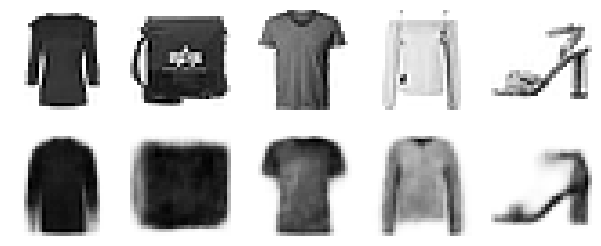

In [ ]:
show_reconstructions(model)

Saving figure vae_generated_images_plot


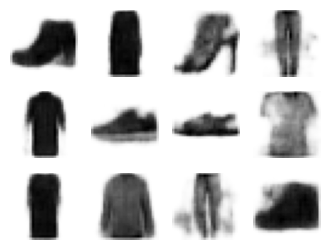

In [ ]:
tf.random.set_seed(0)
codings = tf.random.normal(shape=[12, latent_dim])
images = decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Saving figure semantic_interpolation_plot


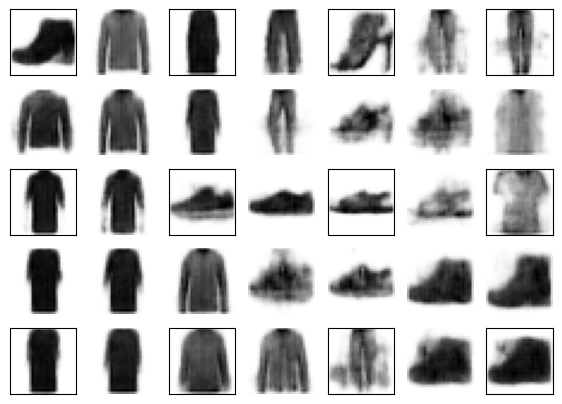

In [ ]:
tf.random.set_seed(10)
np.random.seed(0)
codings_grid = tf.reshape(codings, [1, 3, 4, latent_dim])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, latent_dim])
images = decoder(interpolated_codings).numpy()
plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

##Curva de rendimiento

313/313 [==============================] - 3s 7ms/step
Evaluación con test: Reconstruction Loss = 0.30213138461112976, DKL Loss = 0.077853724360466, Classification Accuracy = 0.8937


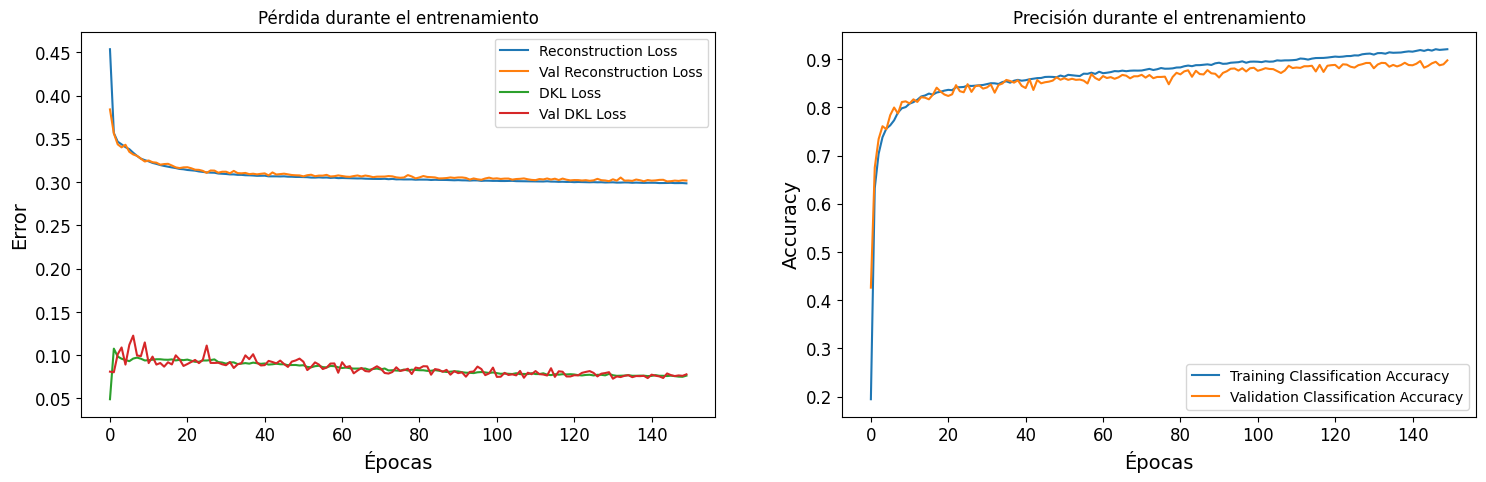

In [ ]:
evaluar_modelo(history, model, X_test,y_test)

##Matriz de confusión

313/313 [==============================] - 2s 6ms/step


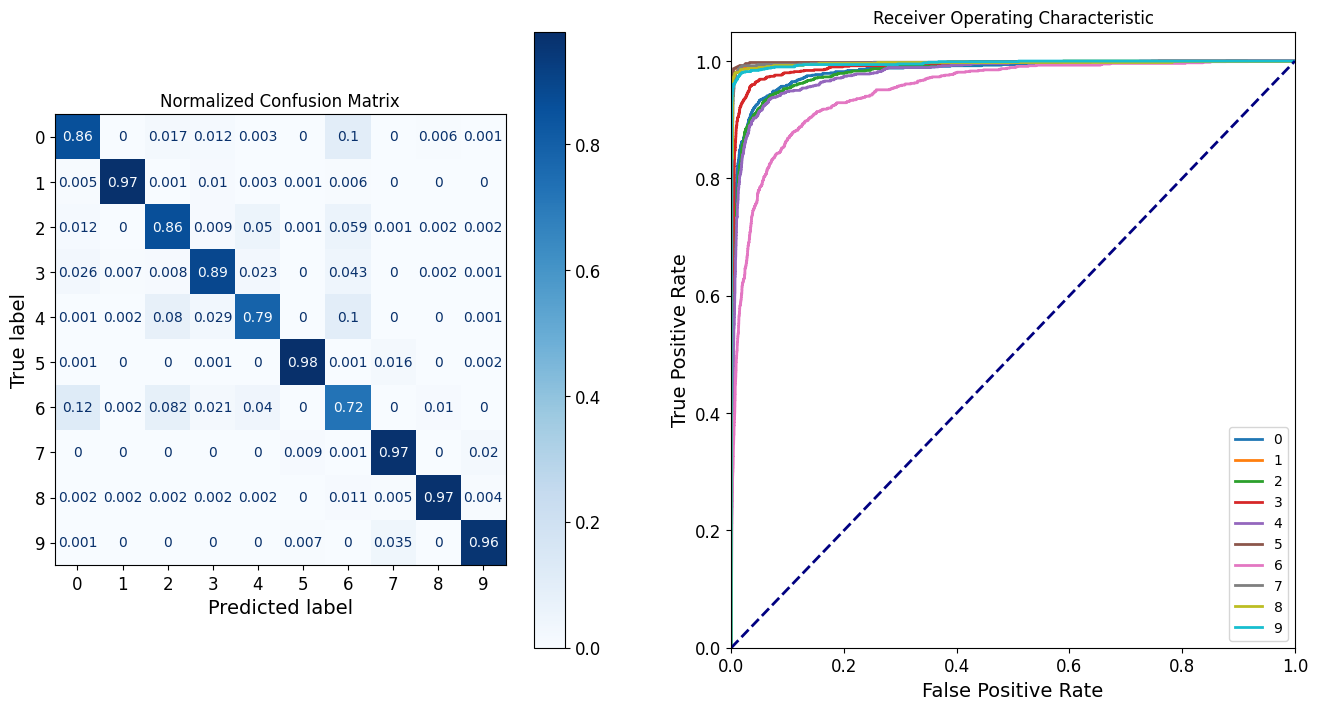

Precision: 0.8988
Recall: 0.8973
F2-score: 0.8974
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.82      0.86      0.84      1000
           3       0.91      0.89      0.90      1000
           4       0.87      0.79      0.82      1000
           5       0.98      0.98      0.98      1000
           6       0.69      0.72      0.71      1000
           7       0.94      0.97      0.96      1000
           8       0.98      0.97      0.97      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
evaluate_classifier(X_test, y_test, model)

## Espacio latente visto con TSNE

313/313 [==============================] - 1s 2ms/step


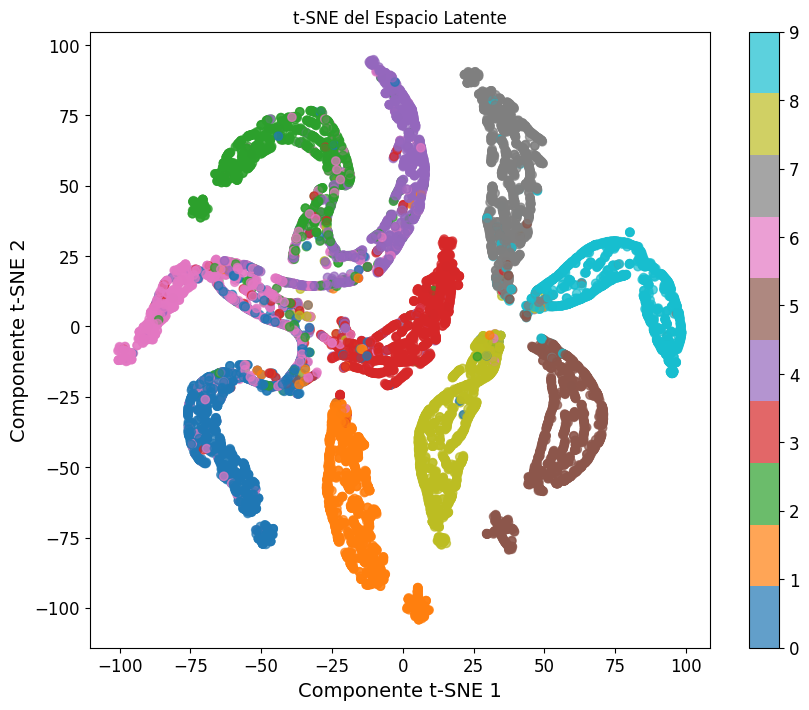

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

encoder = tf.keras.Model(inputs=model.get_layer('conv1').input, outputs=model.get_layer('classifier').output)

codings = encoder.predict(X_test)

# Paso 2: Aplicar t-SNE
# Reducimos a 2D para visualización
tsne = TSNE(n_components=2, random_state=42)
codings_2d = tsne.fit_transform(codings)

# Paso 3: Graficar con colores según las clases
plt.figure(figsize=(10, 8))
scatter = plt.scatter(codings_2d[:, 0], codings_2d[:, 1], c=y_test, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE del Espacio Latente")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.show()


## GradCam++

Capa: conv1


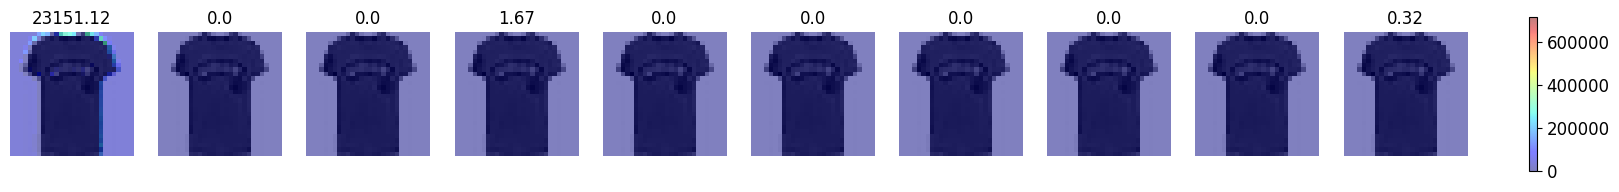

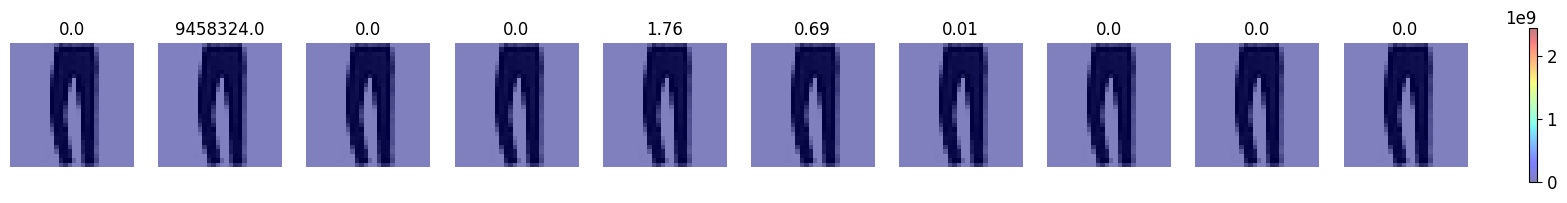

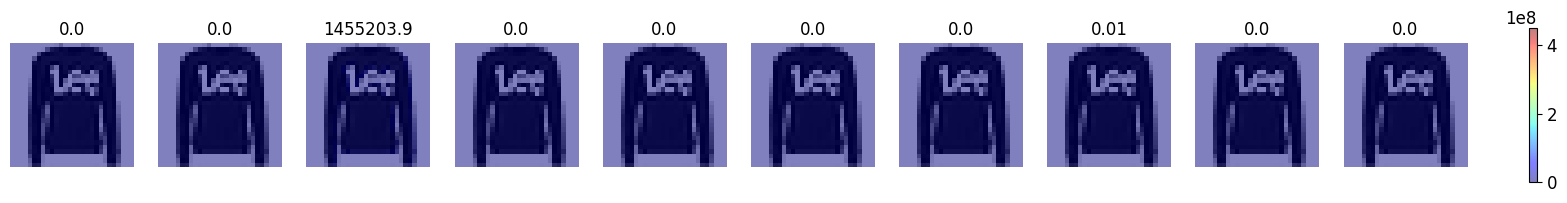

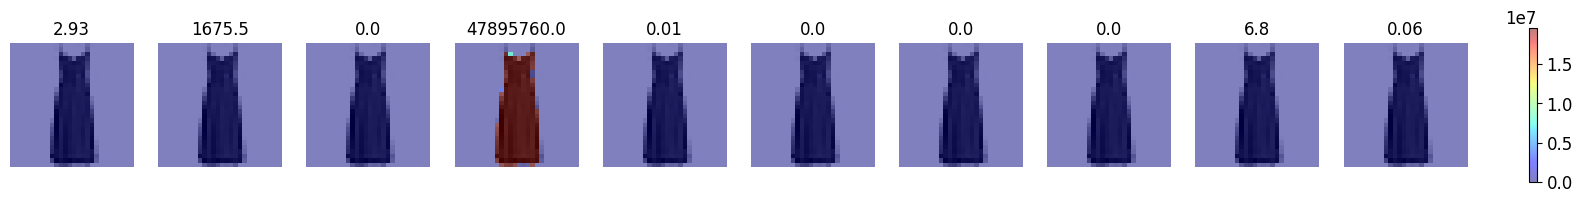

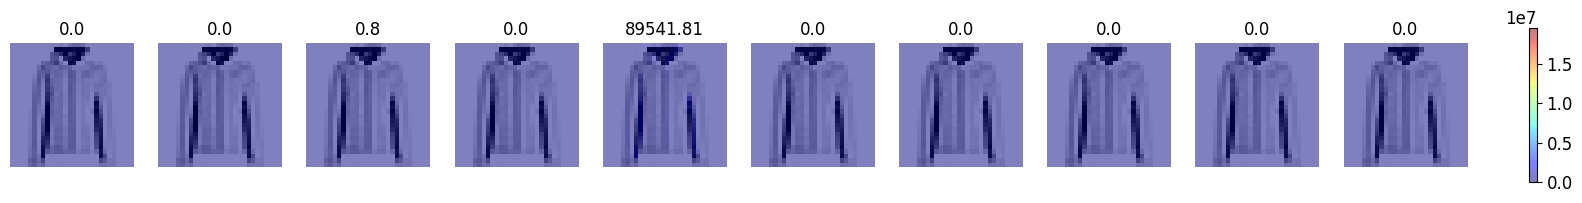

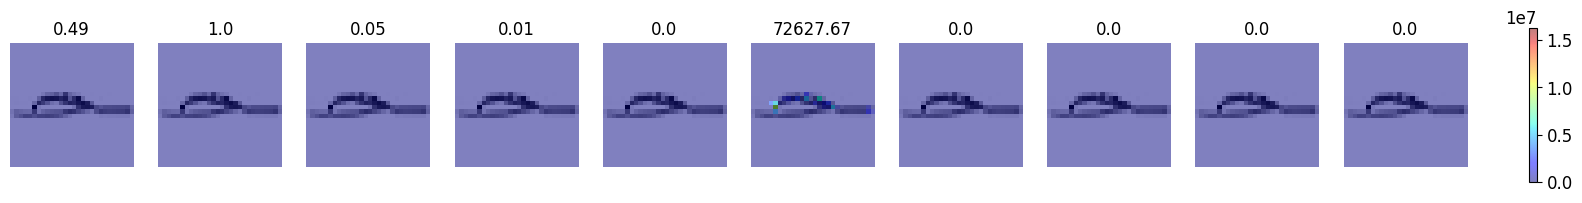

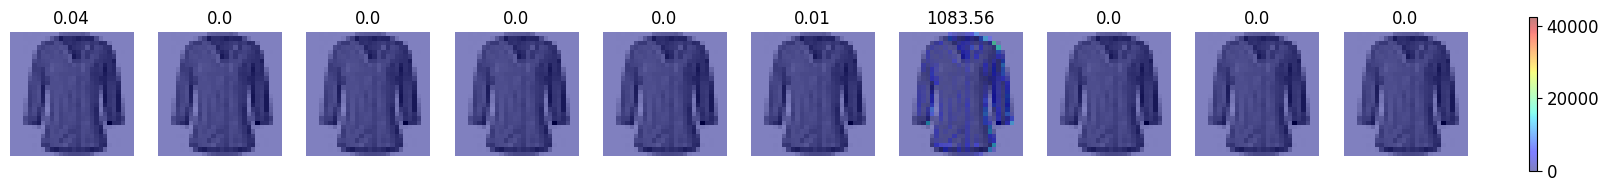

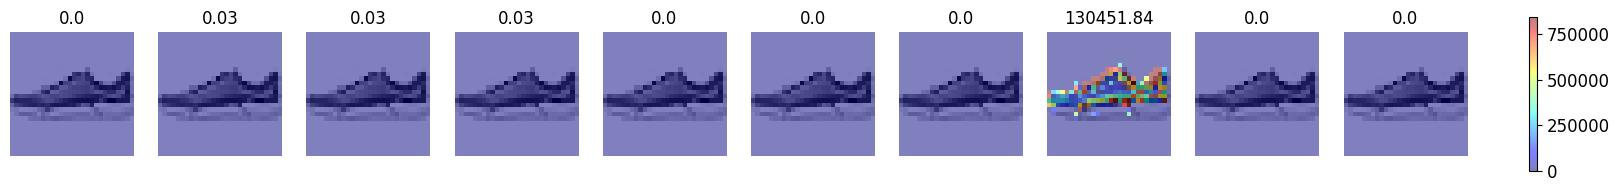

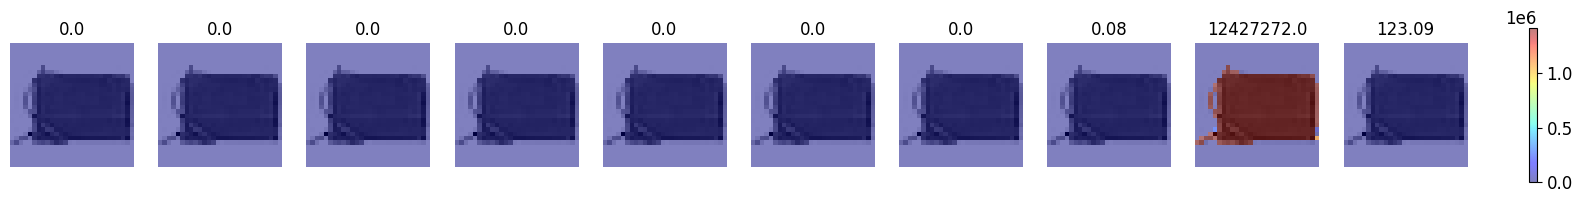

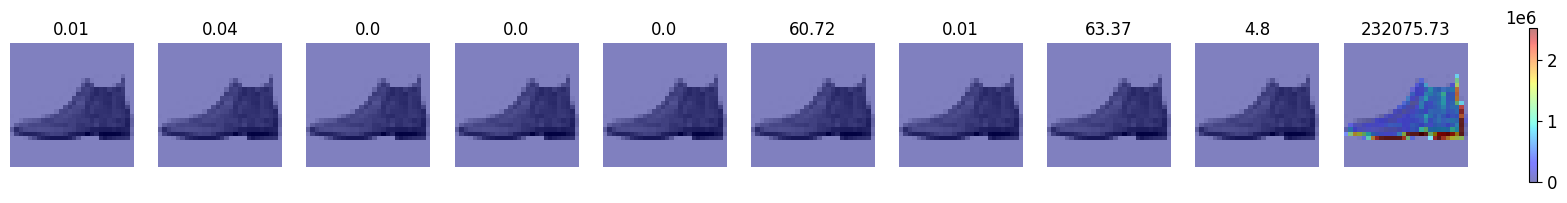

In [ ]:
layers = ['conv1']
generate_and_plot_cam_for_output(model, X_test, y_test, layers, output_name='classifier', class_mode=True)

Capa: conv2


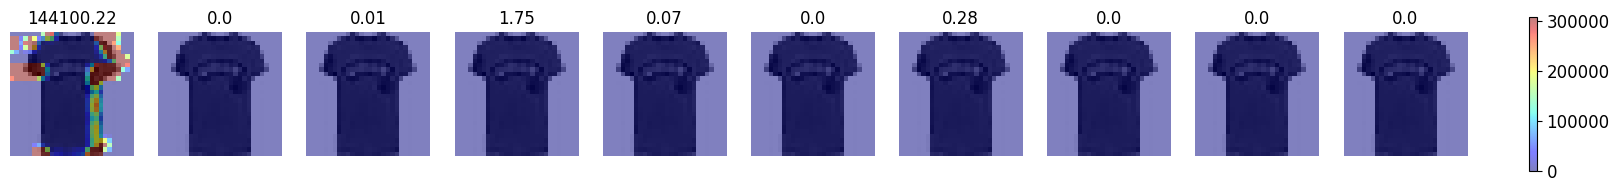

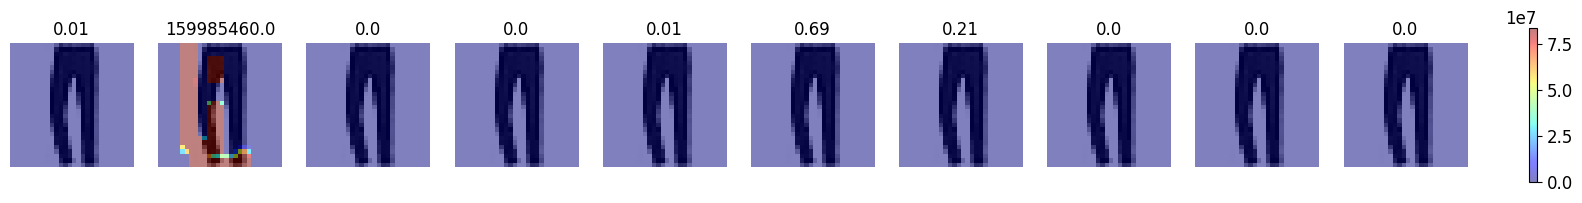

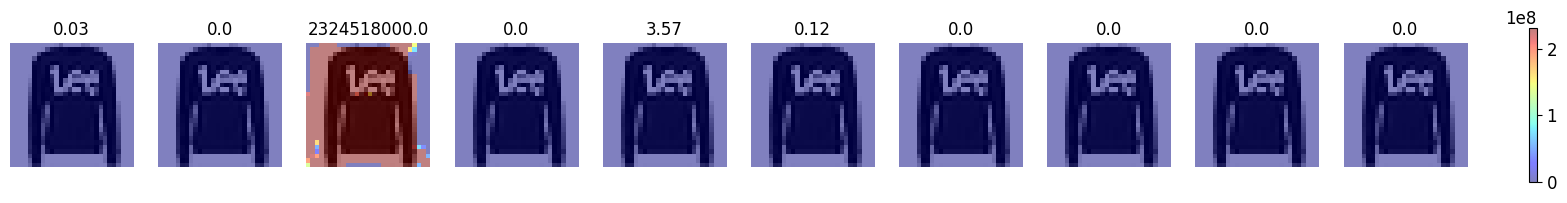

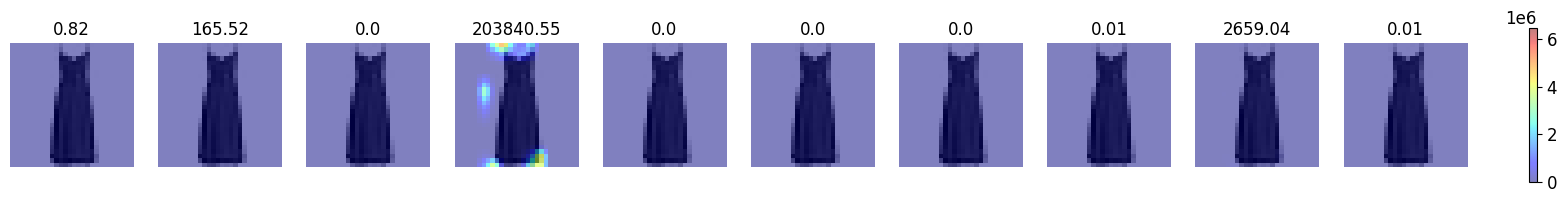

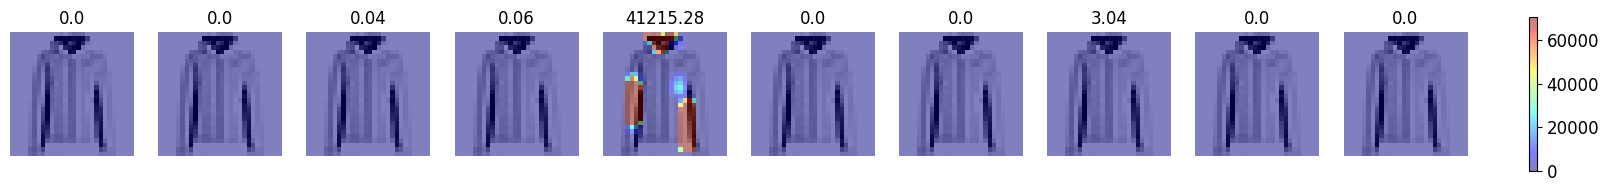

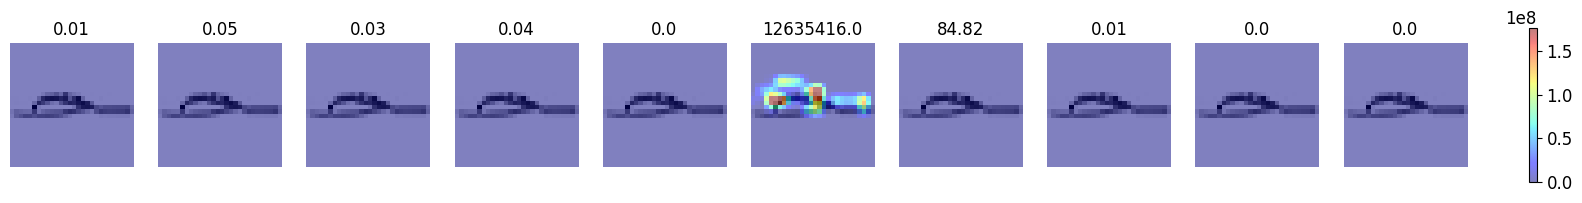

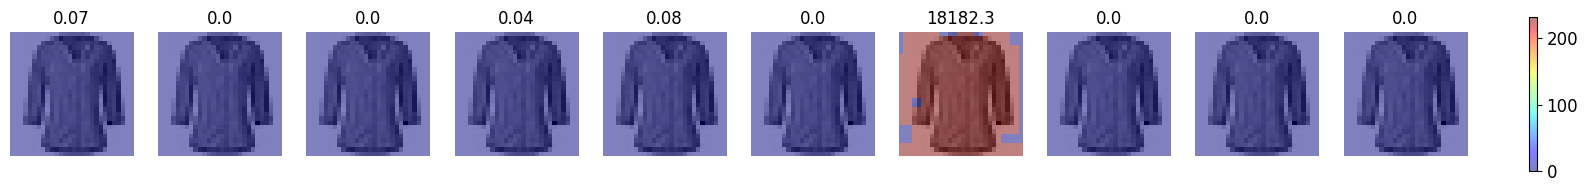

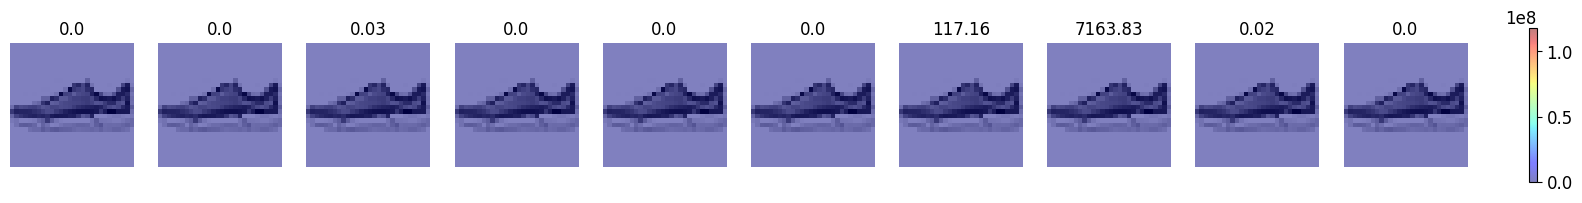

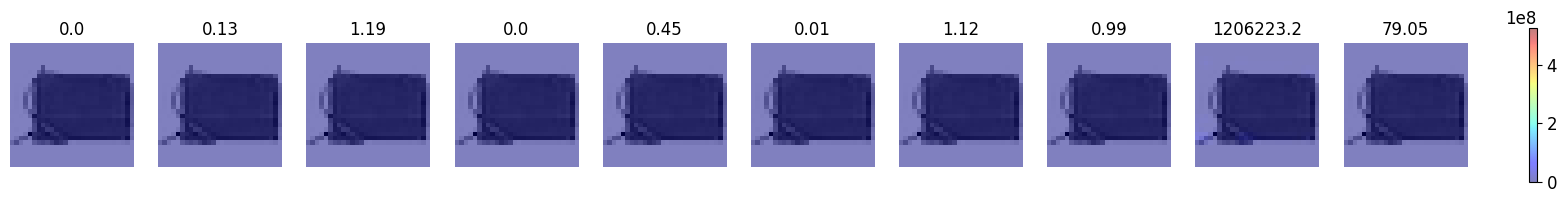

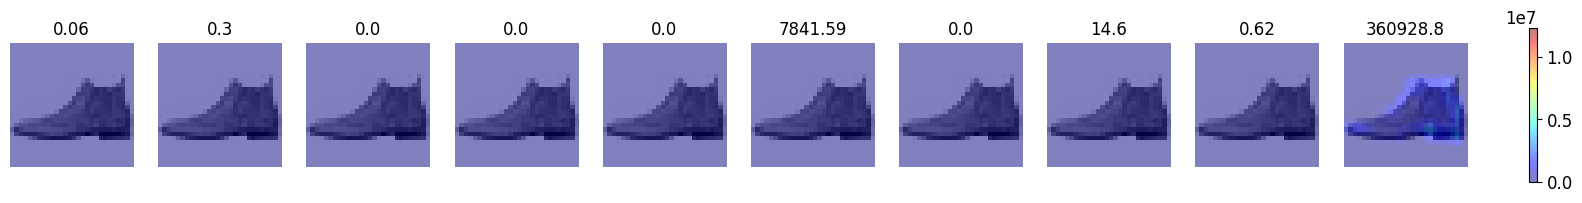

In [ ]:
layers = ['conv2']
generate_and_plot_cam_for_output(model, X_test, y_test, layers, output_name='classifier', class_mode=True)

Capa: conv3


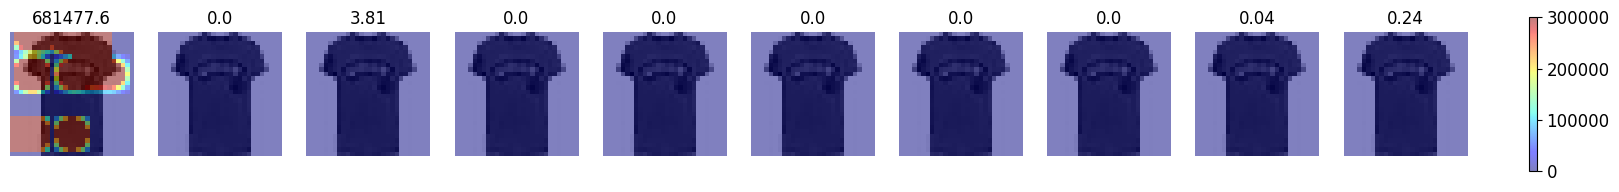

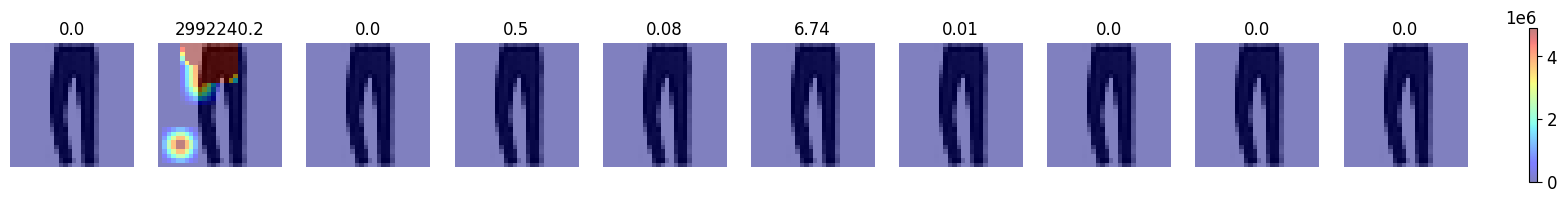

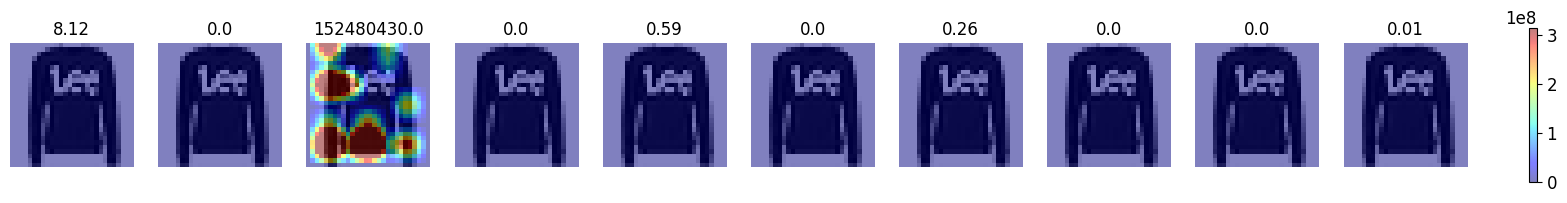

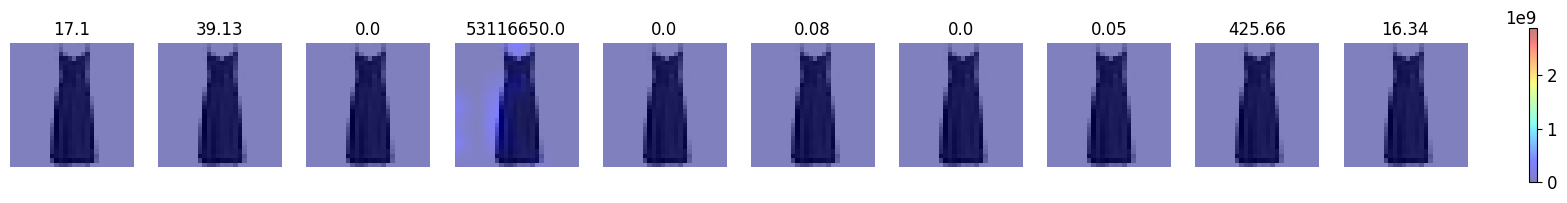

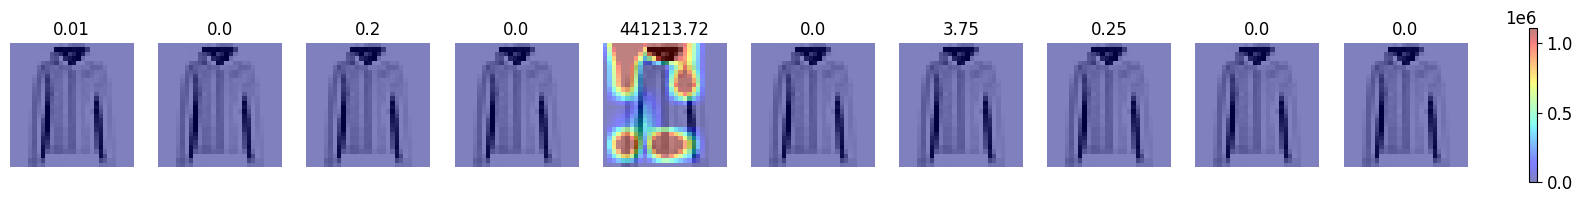

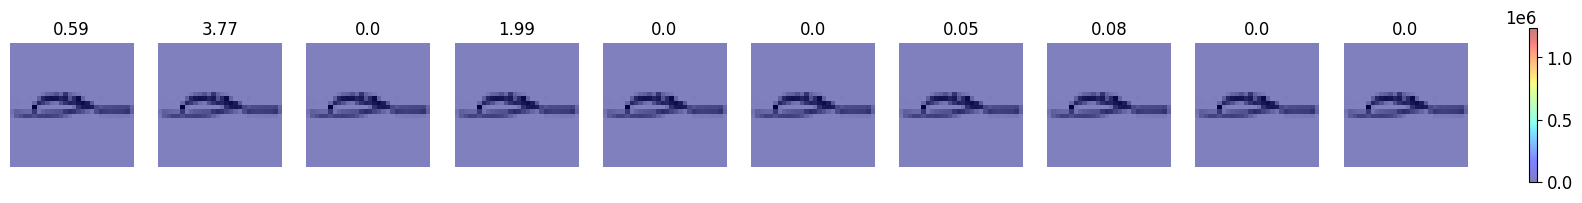

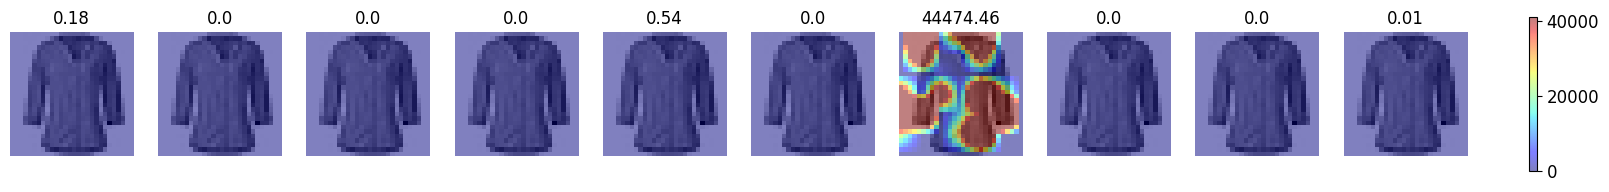

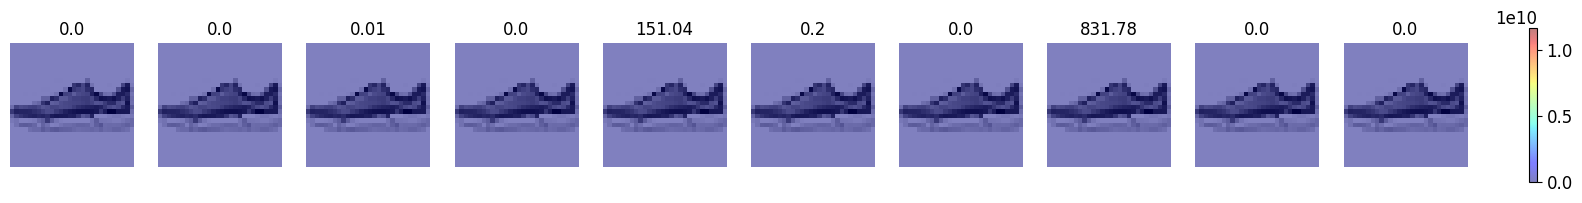

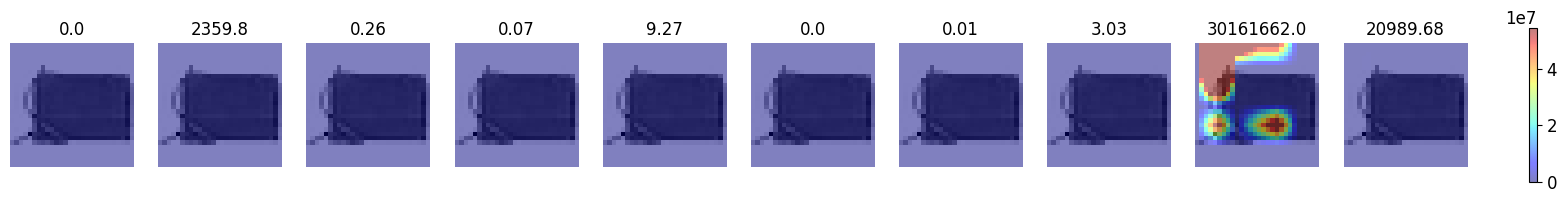

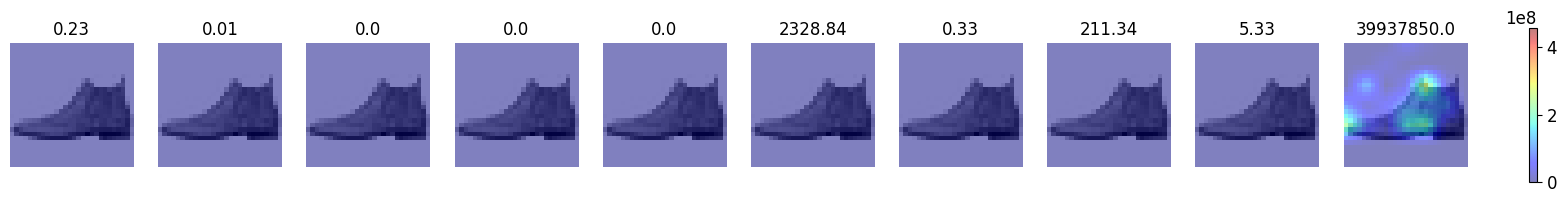

In [ ]:
layers = ['conv3']
generate_and_plot_cam_for_output(model, X_test, y_test, layers, output_name='classifier', class_mode=True)


Capa: Capa_h


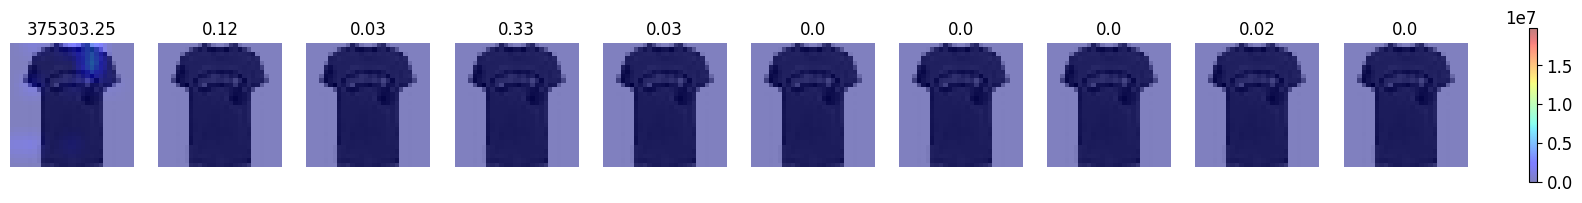

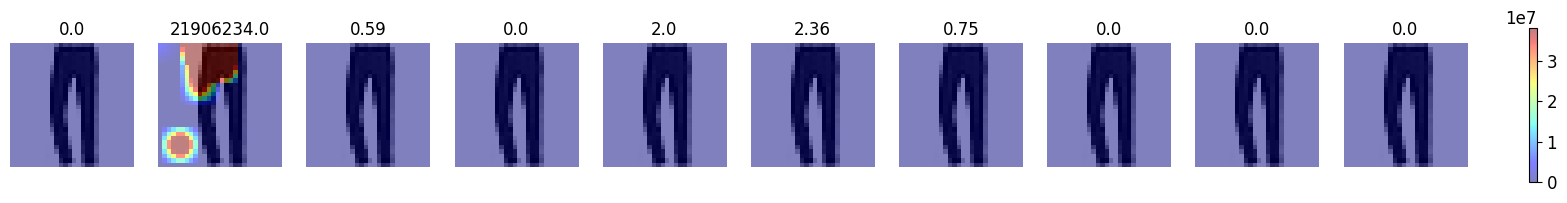

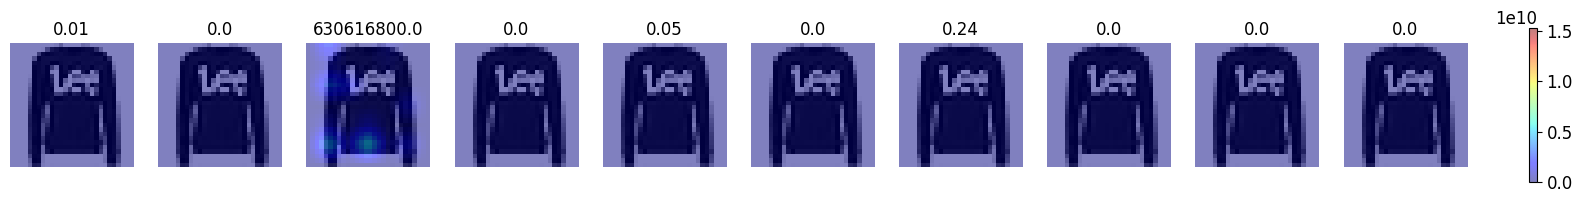

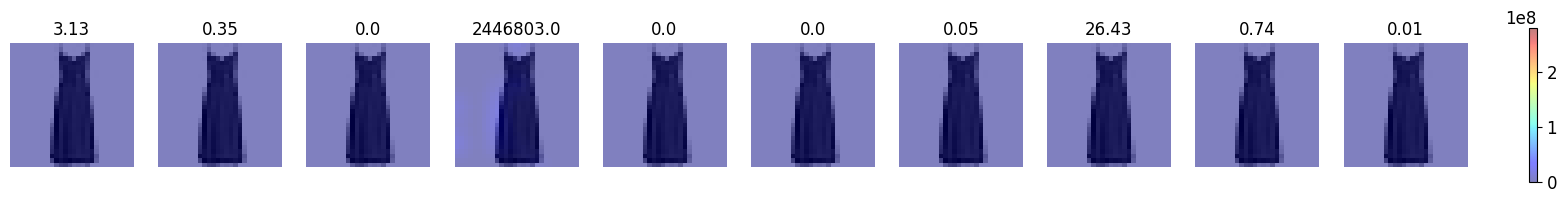

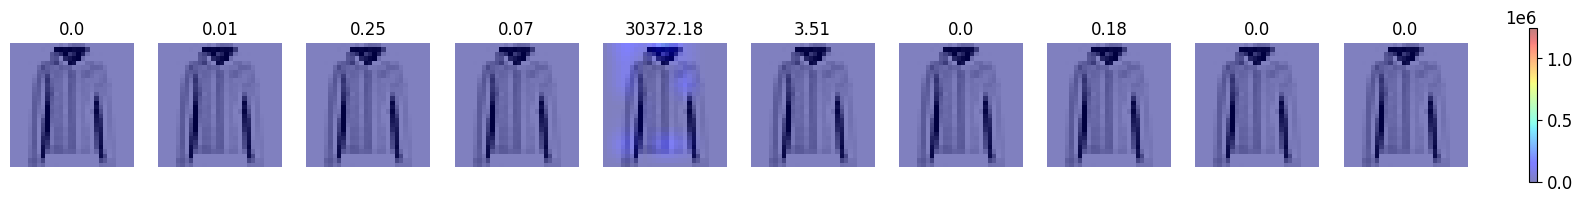

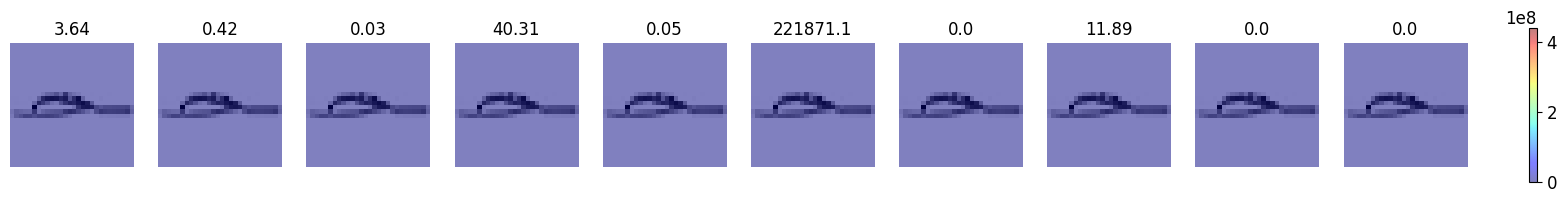

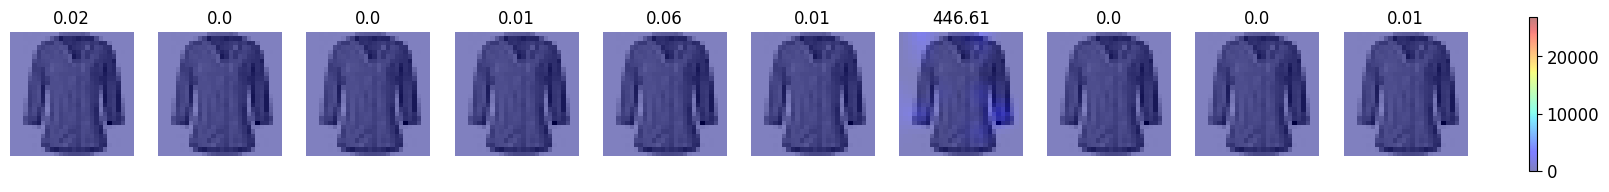

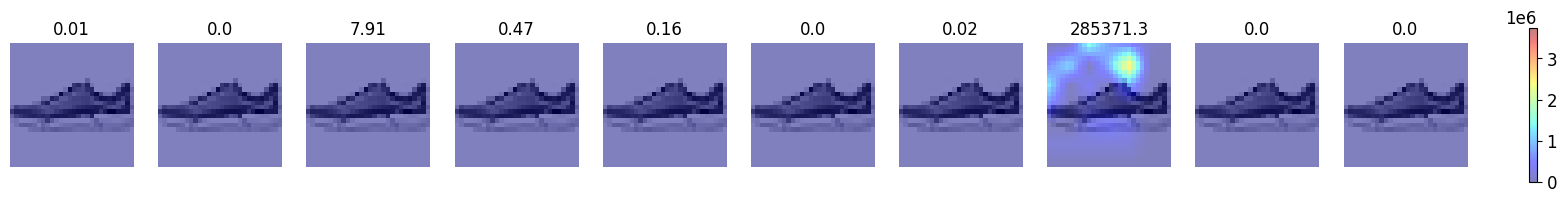

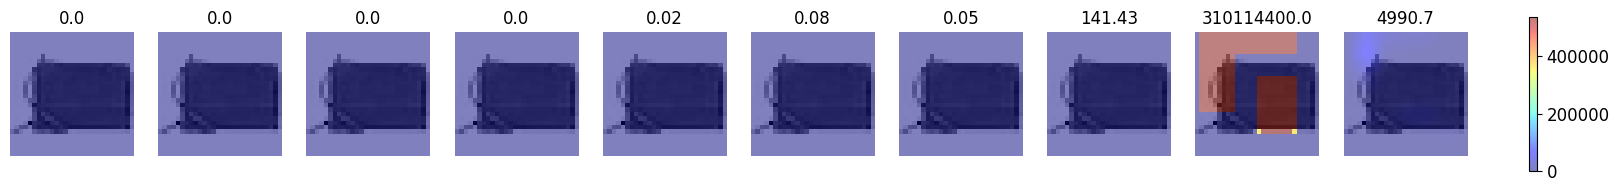

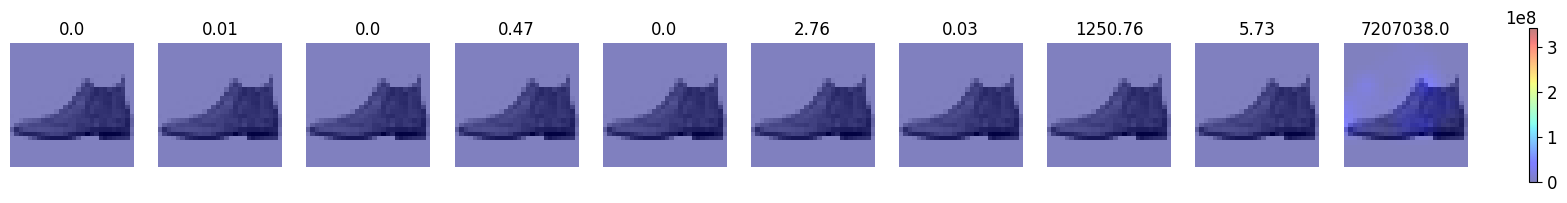

In [ ]:
layers = ['Capa_h']
generate_and_plot_cam_for_output(model, X_test, y_test, layers, output_name='classifier', class_mode=True)
